# Introduction to Fraud Detection
###  What is Anomaly Detection
- An anomaly can be seen as data that deviates substantially from the norm 
- Anomaly detection is the process of identifying rare observations which differ substantially from the majority of the data from where they are drawn
- Applications include intrusion detection, fraud detection, fault detection, healthcare monitoring etc

- Fraud detection is the process of detecting anomalous financial records from within a broader set of normal transactions.
- The data is typically tabular in nature i.e. data sets with rows and columns
- It is important to have access to histrorical instances of confirmed fraudulent behaviour i.e. labels or our target variable, which are often issued by a bank or third party
- Because fraud is by definition less frequent than normal behaviour within a financial services ecosystem, there will be far less confirmed historical instances of fraudulent behaviour compared with the known good/normal behaviour, leading to an imbalance between the fraudulent and non-fraudulent samples

- Feature engineering is crucial, as it involves converting domain knowledge from fraud analysts and investigators into data that can be used to detect suspicious behaviours
- The features/data is typically aggregated at the customer-level, or at the transaction-level, depending on the use-case. Some approaches even combine the two
- Network data i.e. how users within a system are connected to one another (if at all), is normally a strong indicator of fraudulent behaviour

- Data sets for fraud detection are notoriously difficulty to access, due to various issues related to data privacy. There are some popular data sets available online, one of which is the ULB Machine Learning Group credit card fraud data set on Kaggle that we'll be using throughout this course


### Loading Libraries

In [2]:
import pandas as pd
import os
import glob
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shap
import xgboost as xgb
from sklearn.metrics import (classification_report, precision_score, recall_score,
                             average_precision_score, roc_auc_score,
                             f1_score, matthews_corrcoef)     
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import accuracy_score


###  Exploring the Credit Card Fraud Data Set

- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [3]:
#You van download directly 
#df = pd.read_csv('credit_card.csv')


Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [4]:
# or using our splited datasets

In [5]:
#to get the current working directory
directory = os.getcwd()
directory=directory+'\\data'

In [6]:
all_files = glob.glob(os.path.join(directory, "*.csv"))

In [7]:
#all_files

In [8]:
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [9]:
df.shape[0]

284807

In [99]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [100]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [101]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

- Training algorithm would be overwhelmingly baised towards the majority class
- Would not be able to learn anything meaningful from the fraudulent minority class
- we can cater for the imbalance in a number of ways
    - Up sample the minority class at training time (synthetic data)
    - Down sample the majority class
    - Choose an approach better suited to highly imbalanced data i.e. anomaly detection algorithms
    - Re-balance the classes at training time using the algorithm's class_weight hyperparameter to penalize the loss function more for misclassifications made on the minority class (hence improving the algorithm's ability to learn the minority class)

### Sampling with a Class Imbalance
- In machine learning, there are traditionally two main types of modelling approaches:
    - Supervised learning (data has a label or target variable i.e. something to learning and correct itself from)
        - Classification - predicting a categorical value i.e. is fraud yes/no
        - Regression - predicting a continuous value i.e. price
    - Unsupervised (data has no label)
        - Clustering - find the natural groupings within the data
        - Dimensionality reduction - reduce higher dimensional data set down to a lower dimensional space i.e. many columns down to fewer columns to potentially help improve model performance
- Fraud detection is typically a supervised, binary classification problem, but unsupervised learning (both clustering and PCA) can be used
- This data set represents a supervised learning problem (binary (yes/no) classification)

In [102]:
y = df['Class']
X = df.drop(['Class','Amount','Time'], axis=1)

## Model validation
- Train set which our model learns from
- Test set (unseen holdout set) which is used to evaluate the effectiveness of the model after training is complete
- Often a 80/20 or 90/10 split depending on the amount of data


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (256326, 28)
X_test: (28481, 28)
y_train: (256326,)
y_test: (28481,)


In [104]:
print("Fraud in y_train:", len(np.where(y_train == 1)[0]))
print("Fraud in y_test", len(np.where(y_test == 1)[0]))

Fraud in y_train: 443
Fraud in y_test 49


### Improving the Logistic Regression Model through Hyperparameter Selection
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [105]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [106]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [107]:
confusion_matrix(y_test, y_pred)

array([[27657,   775],
       [    4,    45]], dtype=int64)

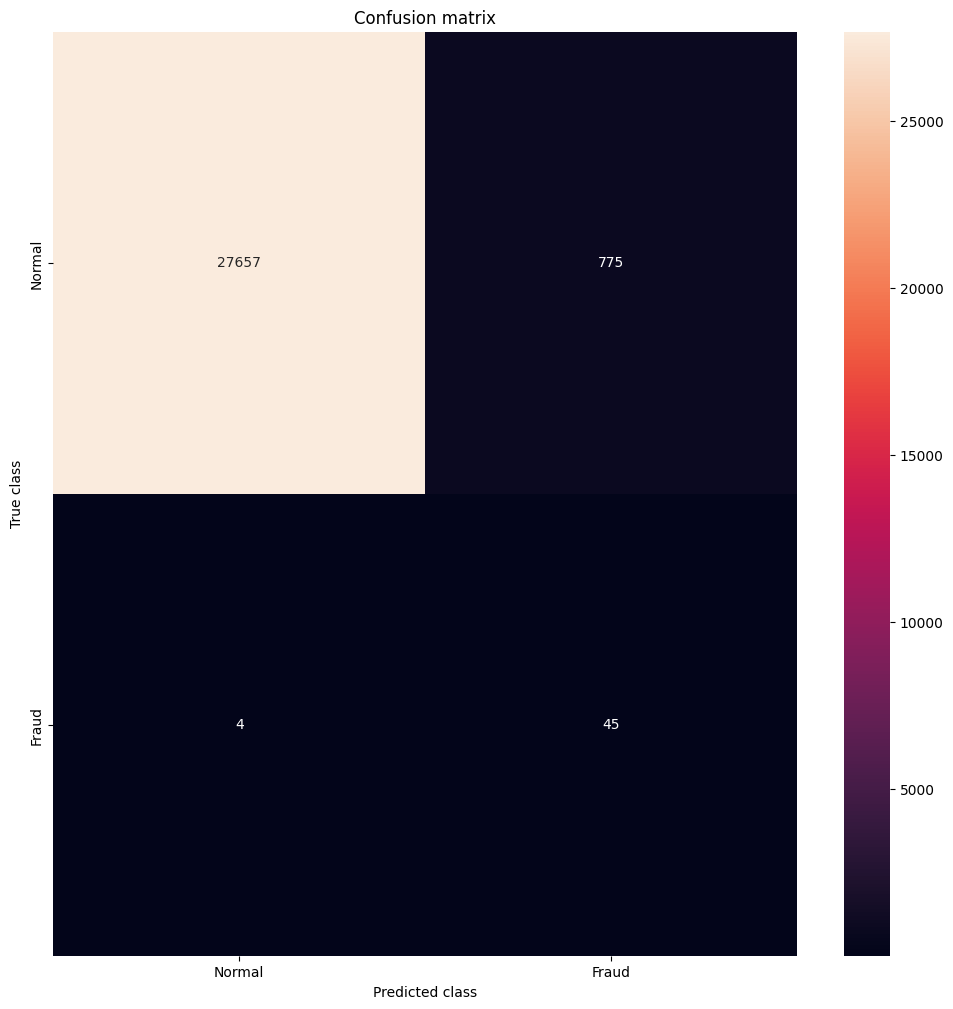

In [108]:
LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Interpreting the Logistic Regression Model
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [109]:
# y = mx + c
# B_0 + B_1*x_1 + B_2*x_2 etc 
model.coef_

array([[ 0.48400318, -0.46079153,  0.09736275,  1.16539782,  0.16291224,
        -0.17368213,  0.08084814, -0.76005345, -0.68351754, -1.46873279,
         0.6172841 , -1.3016    , -0.3970373 , -1.35726908, -0.08044446,
        -0.93149893, -1.01520931, -0.24598021,  0.15143032, -0.35166739,
         0.3869633 ,  0.5860313 , -0.31382196, -0.13406144, -0.33186213,
        -0.42679528, -0.20485846,  0.4507536 ]])

In [110]:
model.intercept_

array([-3.81460738])

In [111]:
model.predict_proba(X_test) 

# true probabilities would require model calibration isotonic regression etc
# https://scikit-learn.org/stable/modules/calibration.html

array([[0.90172788, 0.09827212],
       [0.9589293 , 0.0410707 ],
       [0.96496459, 0.03503541],
       ...,
       [0.94511721, 0.05488279],
       [0.97703552, 0.02296448],
       [0.94834977, 0.05165023]])

# SHAP
- The Shapley value is the average expected marginal contribution of one feature after all possible feature combinations have been considered. 
- Shapley value helps to determine a payoff for all of the features when each feature might have contributed more or less than the others.

In [112]:
shap.initjs()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


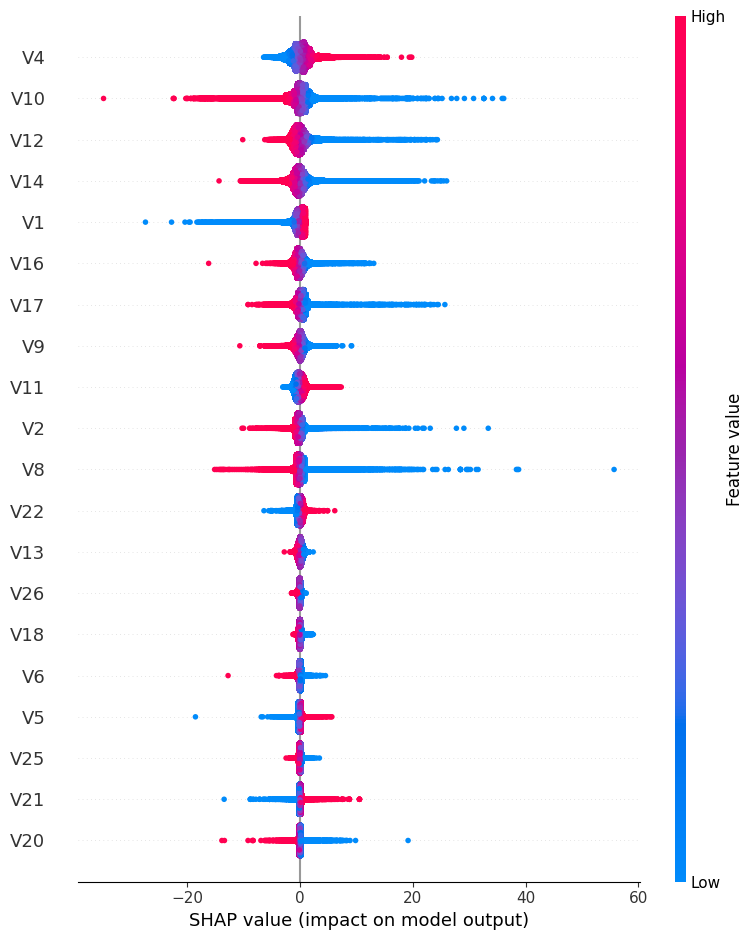

In [113]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

###  Training an XGBoost Model
- https://xgboost.readthedocs.io/en/stable/get_started.html

In [114]:
# XGBoost is a popular and efficient open-source implementation of the gradient boosted trees algorithm. 
# Gradient boosting is a supervised learning algorithm, which attempts to accurately predict a target 
# variable by combining the estimates of a set of simpler, weaker models.
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [115]:
y_pred = model.predict(X_test)

In [116]:
confusion_matrix(y_test, y_pred)

array([[28430,     2],
       [    9,    40]], dtype=int64)

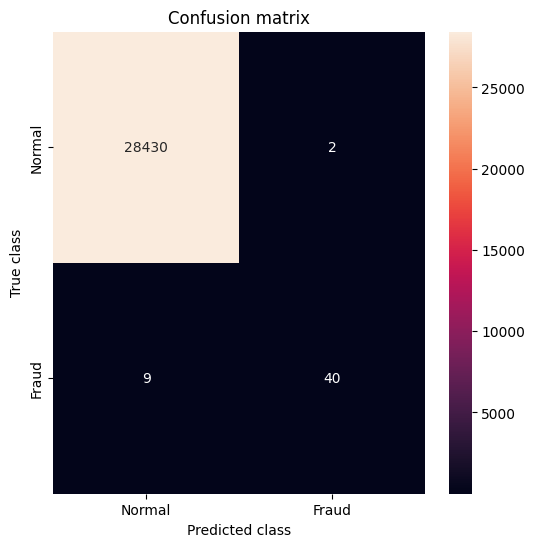

In [117]:
LABELS = ["Normal", "Fraud"]

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

###  Improving the XGBoost Model through Hyperparameter Selection
- https://xgboost.readthedocs.io/en/stable/python/index.html

In [33]:
model = xgb.XGBClassifier(scale_pos_weight=100)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [34]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
confusion_matrix(y_test, y_pred)

array([[28427,     5],
       [    8,    41]], dtype=int64)

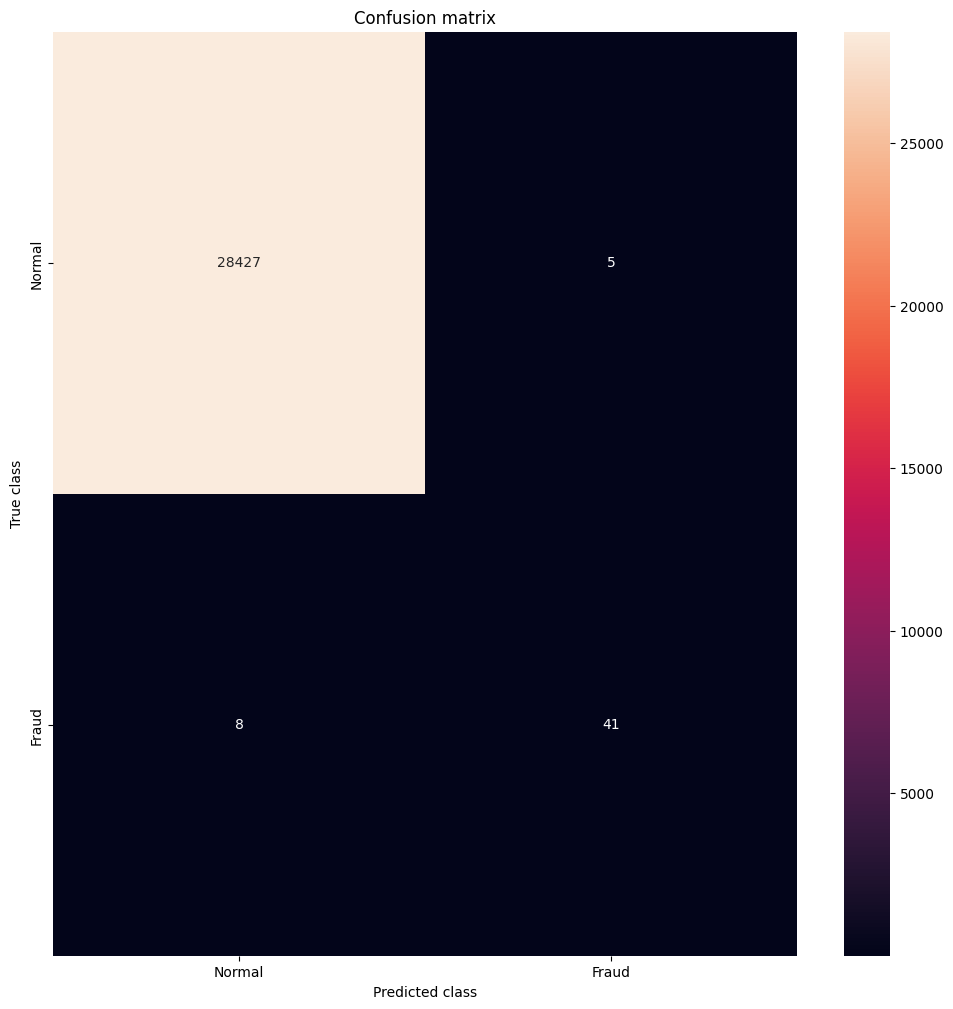

In [36]:
LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

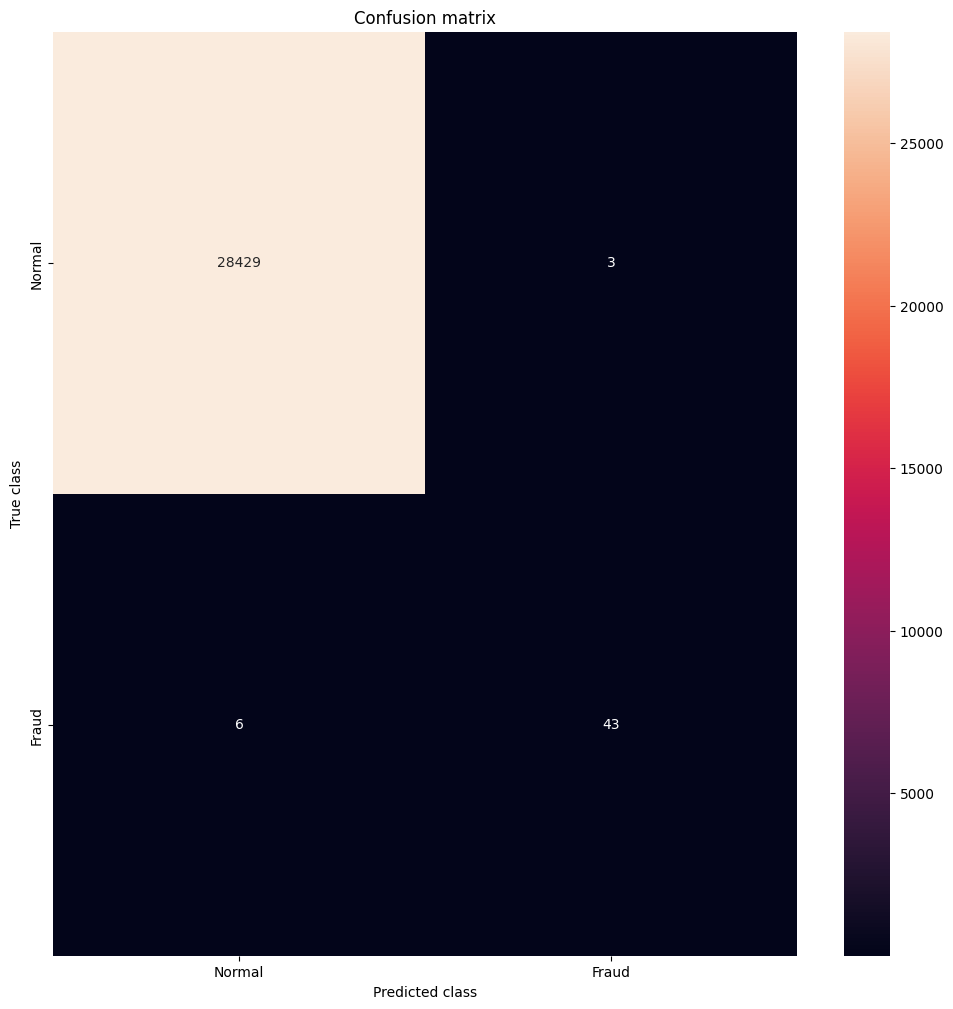

In [37]:
model = xgb.XGBClassifier(max_depth=5, scale_pos_weight=100) 
# max_depth specifies the maximum depth to which each tree will be built.
# reduces overfitting
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Interpreting the XGBoost Model
- https://xgboost.readthedocs.io/en/stable/python/index.html

import xgboost as xgb

model = xgb.XGBClassifier(max_depth=5, scale_pos_weight=100)

model.fit(X_train, y_train)

In [40]:
model.classes_

array([0, 1], dtype=int64)

In [41]:
model.feature_importances_

array([0.01778892, 0.006522  , 0.01161652, 0.04864641, 0.00839465,
       0.01592866, 0.02007158, 0.02973094, 0.00941193, 0.04264095,
       0.01003185, 0.02240502, 0.01880649, 0.52212244, 0.01488954,
       0.00652269, 0.08942025, 0.00986922, 0.01701785, 0.01133021,
       0.01525105, 0.0066182 , 0.01258562, 0.00372731, 0.00570192,
       0.01185634, 0.00590739, 0.00518408], dtype=float32)

### Lecture 15: The Accuracy Paradox

In [42]:
from sklearn.metrics import accuracy_score

y_pred_acc = np.zeros(len(y_test))
print('Accuracy Score:', round(accuracy_score(y_test, y_pred_acc), 5))

Accuracy Score: 0.99828


### Implementing Performance Metrics in scikit-learn

In [44]:
# Precision is the proportion of correctly predicted fraudulent instances among all instances predicted as fraud
# TP / TP + FP
# 43 / 3 + 43 = 0.934

precision_score(y_test, y_pred)

0.9347826086956522

In [45]:
# Recall is the proportion of the fraudulent instances that are successfully predicted
# TP / TP + FN
# 43 / 6 + 43 = 0.877
recall_score(y_test, y_pred)

0.8775510204081632

In [46]:
# F1-score is the harmonic balance of precision and recall (can be weighted more towards P or R if need be)
# F = 2 * (Precision * Recall)/(Precision + Recall)
# F = 2 * (0.934 * 0.877)/(0.934 + 0.877)
# F = 0.905
f1_score(y_test, y_pred)

0.9052631578947369

In [47]:
# AUROC/AUC = Area under the Receiver Operating Characteristic curve
# plot the TPR (Recall) and FPR at various classification thresholds
# FPR = FP / FP + TN
# Good measure of overall performance
roc_auc_score(y_test, y_pred)

0.9387227527476945

In [48]:
# AUPRC = Area under the Precision-Recall curve
# Better alternative to AUC as doesn't include TN which influences the scores significantly in highly imbalanced data
# calculates the area under the curve at various classification thresholds
average_precision_score(y_test, y_pred)

0.8205300988809707

In [49]:
# Classification report summarizes the classification metrics at the class and overall level
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.93      0.88      0.91        49

    accuracy                           1.00     28481
   macro avg       0.97      0.94      0.95     28481
weighted avg       1.00      1.00      1.00     28481



### Threshold Optimization using Performance Metrics

In [52]:
model_xgb = xgb.XGBClassifier(max_depth=5, scale_pos_weight=100)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[28429,     3],
       [    6,    43]], dtype=int64)

In [53]:
# probability of being fraudulent
y_pred = model_xgb.predict_proba(X_test)[:,1]
y_pred

array([1.0238165e-05, 1.4227397e-05, 5.2480987e-06, ..., 2.7707663e-06,
       1.6304925e-06, 8.0974127e-07], dtype=float32)

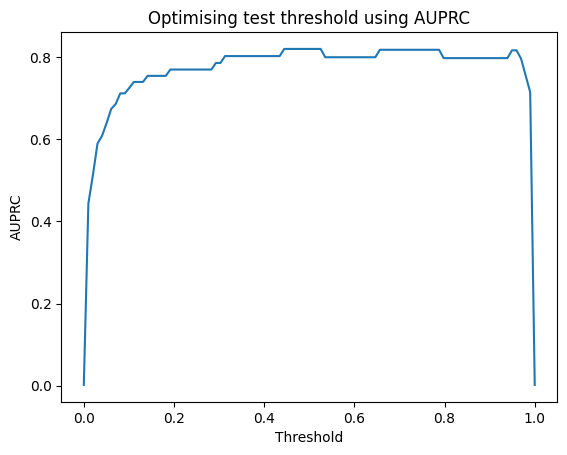

In [54]:

threshold_list = []
auprc_list = []
thresholds = np.linspace(0, 1, 100)

for threshold in thresholds:
    y_pred_thresh = [1 if e > threshold else 0 for e in y_pred]
    threshold_list.append(threshold)
    
    # AUPRC
    auprc_score = average_precision_score(y_test, y_pred_thresh)
    auprc_list.append(auprc_score)

# plot curve
threshold_df = pd.DataFrame(threshold_list, auprc_list).reset_index()
threshold_df.columns = ['AUPRC', 'Threshold']

plt.plot(threshold_df['Threshold'], threshold_df['AUPRC'])
plt.title("Optimising test threshold using AUPRC")
plt.xlabel('Threshold')
plt.ylabel('AUPRC')
plt.savefig('Optimising threshold using AUPRC');
plt.show()

In [55]:
threshold_df.sort_values(by='AUPRC', ascending=False)

,AUPRC,Threshold
50,0.820530,0.505051
44,0.820530,0.444444
52,0.820530,0.525253
51,0.820530,0.515152
48,0.820530,0.484848
...,...,...
3,0.589815,0.030303
2,0.513295,0.020202
1,0.444110,0.010101
0,0.001720,0.000000


In [56]:
threshold_df.loc[(threshold_df['AUPRC'] >= 0.82)]

,AUPRC,Threshold
44,0.82053,0.444444
45,0.82053,0.454545
46,0.82053,0.464646
47,0.82053,0.474747
48,0.82053,0.484848
49,0.82053,0.494949
50,0.82053,0.505051
51,0.82053,0.515152
52,0.82053,0.525253


### Threshold Optimization using Total Cost of Fraud

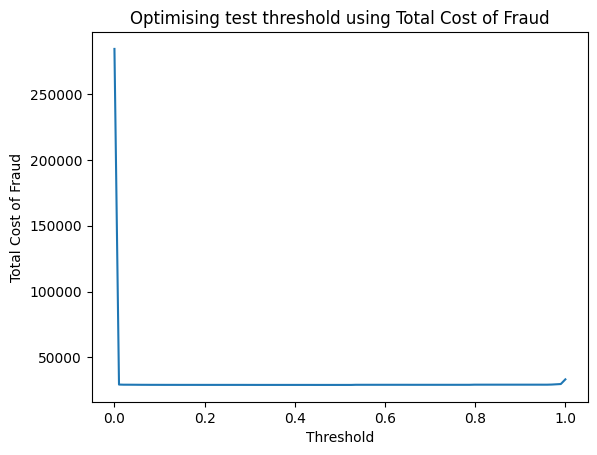

In [57]:
threshold_list = []
tcf_list = []
cost_tn = 1
cost_fp = 10
cost_fn = 100
cost_tp = 1
thresholds = np.linspace(0, 1, 100)

for threshold in thresholds:
    y_pred_thresh = [1 if e > threshold else 0 for e in y_pred]
    threshold_list.append(threshold)

    # Total Cost of Fraud
    conf_matrix_xgb = confusion_matrix(y_test, y_pred_thresh)
    tcf_score = (conf_matrix_xgb[0][0] * cost_tn) + (conf_matrix_xgb[0][1] * cost_fp) + (conf_matrix_xgb[1][0] * cost_fn) + (conf_matrix_xgb[1][1] * cost_tp)
    tcf_list.append(tcf_score)

# plot curve
threshold_df = pd.DataFrame(threshold_list, tcf_list).reset_index()
threshold_df.columns = ['TCF', 'Threshold']

plt.plot(threshold_df['Threshold'], threshold_df['TCF'])
plt.title("Optimising test threshold using Total Cost of Fraud")
plt.xlabel('Threshold')
plt.ylabel('Total Cost of Fraud')
plt.savefig('Optimising threshold using Total Cost of Fraud');
plt.show()

In [ ]:
# if threshold = 0, then everything is fraud (lots of false positives which cost $10 each)
# if threshold = 1, then everything is non-fraudulent (quite a few missed cases of fraud which cost $100 each)
# optimal threshold for this model is around 50% (already well balanced)

threshold_df.sort_values(by='TCF', ascending=True)

### Up-sampling the Minority Class with SMOTE

In [67]:
y = df['Class']
X = df.drop(['Class','Amount','Time'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
model_xgb = xgb.XGBClassifier(max_depth=5, scale_pos_weight=100)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[28429,     3],
       [    6,    43]], dtype=int64)

In [68]:

print('Original dataset shape %s' % Counter(y_train))
sm = SMOTE(sampling_strategy=1, random_state=42, k_neighbors=5)
# sampling_strategy = ratio of minority to majority after resampling
# k_neighbors = defines neighborhood of samples to use to generate synthetic samples. Decrease to reduce false positives.
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))


Original dataset shape Counter({0: 255883, 1: 443})
Resampled dataset shape Counter({0: 255883, 1: 255883})


In [69]:
model_xgb = xgb.XGBClassifier(max_depth=5, scale_pos_weight=100)
model_xgb.fit(X_res, y_res)
y_pred = model_xgb.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[28341,    91],
       [    5,    44]], dtype=int64)

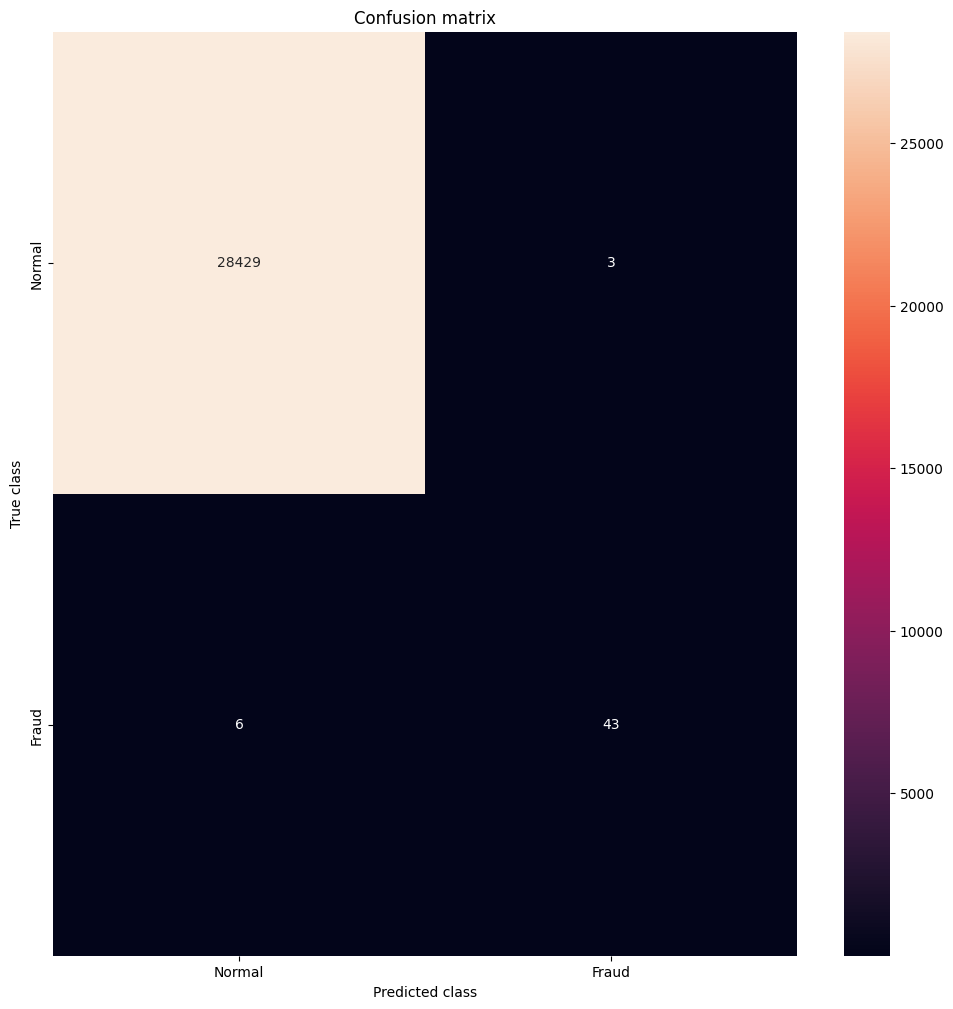

In [70]:

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [73]:
y_pred_acc = np.zeros(len(y_test))
print('Accuracy Score:', round(accuracy_score(y_test, y_pred_acc), 5))

Accuracy Score: 0.99828


In [72]:
# Classification report summarizes the classification metrics at the class and overall level
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.33      0.90      0.48        49

    accuracy                           1.00     28481
   macro avg       0.66      0.95      0.74     28481
weighted avg       1.00      1.00      1.00     28481

